In [1]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

## X-RAY
from src.XRAY import xray_BJ

## W 
import pysptools.abundance_maps as amp
nnls = amp.NNLS() # nonnegative constrained least squares and then row-normalize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
obj = load("data/CB_10locs_complete_nonegpm25mpm1.joblib")
df = obj["df"]
Y = obj["Y"]
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label = ["PM1", "PM2.5-PM1", "PM10-PM2.5", "TSP-PM10", "BC", "CO", "NO", "NO2"]
b = pd.to_numeric(df['bulldozer'], errors='coerce')
d = pd.to_numeric(df['downwind'],  errors='coerce')
df['bulldozerxdownwind'] = (b*d).astype('Int8')

In [4]:
# Pretty labels
def pretty_y(t):
    mapping = {
        'pm1': "PM1",
        'pm25mpm1': "PM2.5-PM1", 
        'pm10mpm25': "PM10-PM2.5", 
        'tspmpm10': "TSP-PM10", 
        'bc': "BC", 
        'co': "CO", 
        'no': "NO", 
        'no2': "NO2"
    }
    return mapping.get(t, t)

def pretty_x(t):
    mapping = {
        "main_plus_interaction": "Bulldozer=1 x Downwind=1",
        "bulldozer[T.1]:downwind[T.1]": "Interaction",
        "bulldozer[T.1]": "Bulldozer=1",
        "downwind[T.1]":  "Downwind=1",
        "location[T.2]": "Location=2", 
        "location[T.5]": "Location=5", 
        "location[T.8]": "Location=8", 
        "am[T.1]": "AM=1",
        "stable[T.1]": "Atmospheric stability=1",
        "temp": "Temperature",
        "windspeed": "Wind speed",
        "humid": "Relative humidity",
        "solar": "Solar radiation", 
        'no': "NO", 
    }
    return mapping.get(t, t)


In [5]:
# Bootstrap results
outdir = Path("results/CB")
outdir.mkdir(parents=True, exist_ok=True)
n_reps = 100

# Data dimension
K = 4
n, J = Y.shape
groups = [0, 1] # ignore NA
G = len(groups)
q_levels = np.array([0, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1], dtype=float)  
Q = len(q_levels)

# Responses and formula for multiple regressions
# PMs & sources
ys_pms = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc']
ss = [f"Source{k}" for k in range(1, K+1)]
formula = (
    "bulldozer*downwind + temp + no + windspeed + am + solar + location"
)
# Gas
ys_gas = ['co', 'no', 'no2']
formula_gas = (
    "bulldozer*downwind + temp + windspeed + am + solar + location"
)

In [6]:
# # Save results
# out_ys_pms = []
# out_ys_gas = []
# out_ss = []
# results_boots = {
#     "time_sourceXray": np.full(n_reps, np.nan, dtype=float),
#     "time_xray":       np.full(n_reps, np.nan, dtype=float),
#     "logvol_sourceXray": np.full(n_reps, np.nan, dtype=float),
    
#     "mu_tilde_hat_sourceXray": np.full((n_reps, K), np.nan, dtype=float),
#     "C_hat_sourceXray": np.full((n_reps, J, K), np.nan, dtype=float),
#     "C_hat_xray":       np.full((n_reps, J, K), np.nan, dtype=float),

#     # quantiles
#     "W_tilde_qbybulldozer_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
#     "W_tilde_qbydownwind_sourceXray":  np.full((n_reps, G, Q, K), np.nan, float),
#     "W_tilde_qbyinteraction_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
#     "W_tilde_qby20230203to0204_sourceXray": np.full((n_reps, G, Q, K), np.nan, float),
    
#     "W_tilde_qbybulldozer_xray": np.full((n_reps, G, Q, K), np.nan, float),
#     "W_tilde_qbydownwind_xray":  np.full((n_reps, G, Q, K), np.nan, float),
#     "W_tilde_qbyinteraction_xray": np.full((n_reps, G, Q, K), np.nan, float),
# }

# win1_start = pd.Timestamp('2023-02-02 11:30', tz='America/New_York')
# win1_end   = pd.Timestamp('2023-02-02 14:45', tz='America/New_York')
# win2_start = pd.Timestamp('2023-02-03 11:30', tz='America/New_York')
# win2_end   = pd.Timestamp('2023-02-03 14:45', tz='America/New_York')
# win3_start = pd.Timestamp('2023-02-04 11:30', tz='America/New_York')
# win3_end   = pd.Timestamp('2023-02-04 14:45', tz='America/New_York')

# for rep in range(n_reps):
#     results = load(outdir/f"Bootstrap/CB_nonegpm25mpm1_K4_bootstrap_rep{rep+1}.joblib")  

#     seed_rep = results["seed"]
#     rng = np.random.default_rng(seed_rep)

#     # Collect results
#     results_boots["time_sourceXray"][rep] = results["time_sourceXray"]
#     results_boots["time_xray"][rep]       = results["time_xray"]
#     results_boots["logvol_sourceXray"][rep] = results["logvol_sourceXray"]

#     results_boots["mu_tilde_hat_sourceXray"][rep] = results["mu_tilde_hat_sourceXray"] # (K,)
#     results_boots["C_hat_sourceXray"][rep] = results["C_hat_sourceXray"]  # (J,K)
#     results_boots["C_hat_xray"][rep]       = results["C_hat_xray"]        # (J,K)

#     results_boots["W_tilde_qbybulldozer_sourceXray"][rep] = results["W_tilde_qbybulldozer_sourceXray"]  # (G,Q,K)
#     results_boots["W_tilde_qbydownwind_sourceXray"][rep]  = results["W_tilde_qbydownwind_sourceXray"]
#     results_boots["W_tilde_qbyinteraction_sourceXray"][rep] = results["W_tilde_qbyinteraction_sourceXray"]

#     results_boots["W_tilde_qbybulldozer_xray"][rep] = results["W_tilde_qbybulldozer_xray"]
#     results_boots["W_tilde_qbydownwind_xray"][rep]  = results["W_tilde_qbydownwind_xray"]
#     results_boots["W_tilde_qbyinteraction_xray"][rep] = results["W_tilde_qbyinteraction_xray"]
    
#     # W
#     ## resample
#     idx = rng.integers(0, n, size=n)
#     Yb = np.asarray(Y)[idx] 
#     rb = Yb.sum(axis=1, keepdims=True)
#     Yb_star = Yb / rb
#     df_b = df.iloc[idx].copy()           # bootstrap sample of the df

#     ## compare Feb 3 to Feb 2 and 4
#     in_win2 = (df_b['date_local'] >= win2_start) & (df_b['date_local'] <= win2_end)
#     in_win13 = (
#         df_b['date_local'].between(win1_start, win1_end, inclusive='both')
#         | df_b['date_local'].between(win3_start, win3_end, inclusive='both')
#     )
#     cov_b_03_vs_0204 = pd.Series(np.where(in_win2, 1, np.where(in_win13, 0, np.nan)), index=df_b.index)

#     ## call W
#     W_star_hat, _, _ = solve_H_right_inverse(Yb_star, results["H_star_hat_sourceXray"])
#     W_tilde_hat_perm = W_star_hat * rb
    
#     ## quantiles of W tilde by covariates
#     results_boots["W_tilde_qby20230203to0204_sourceXray"][rep] = quantiles_by_group(W_tilde_hat_perm, cov_b_03_vs_0204, q_levels)

#     ## attach W as columns "Source k" to df_b
#     W_df = pd.DataFrame(W_tilde_hat_perm, columns=ss, index=df_b.index)
#     df_b = pd.concat([df_b, W_df], axis=1)

#     ## run regressions
#     coef_ys_pms = run_multireg(df = df_b, ys = ys_pms, formula_rhs = formula, save_all=False, add_main_plus=True)
#     coef_ys_gas = run_multireg(df = df_b, ys = ys_gas, formula_rhs = formula_gas, save_all=False, add_main_plus=True)
#     coef_ss = run_multireg(df = df_b, ys = ss, formula_rhs = formula, save_all=False, add_main_plus=True)

#     ## save
#     out_ys_pms.append(coef_ys_pms)
#     out_ys_gas.append(coef_ys_gas)
#     out_ss.append(coef_ss)
    
# out_ys = pd.concat(out_ys_pms + out_ys_gas, ignore_index=True)
# out_ss = pd.concat(out_ss, ignore_index=True)

# dump({"results_boots": results_boots,
#       "out_ys": out_ys,
#       "out_ss": out_ss}, outdir/"Bootstrap/CB_nonegpm25mpm1_K4_100bootstraps.joblib")   

In [7]:
d = load(outdir/"Bootstrap/CB_nonegpm25mpm1_K4_100bootstraps.joblib")
results_boots, out_ys, out_ss = d["results_boots"], d["out_ys"], d["out_ss"]

# Bootstrap distribution summary
summary_ys = (
    out_ys
    .groupby(["response","term"], as_index=False)
    .agg(coef=("coef", "mean"),
         se=("coef", lambda x: x.std(ddof=1)),
         lo=("coef", lambda x: x.quantile(0.025)),
         hi=("coef", lambda x: x.quantile(0.975)))
)

summary_ss = (
    out_ss
    .groupby(["response","term"], as_index=False)
    .agg(coef=("coef", "mean"),
         se=("coef", lambda x: x.std(ddof=1)),
         lo=("coef", lambda x: x.quantile(0.025)),
         hi=("coef", lambda x: x.quantile(0.975)))
)

In [8]:
np.nanmean(results_boots["mu_tilde_hat_sourceXray"], axis=0)

array([1.23755303, 1.36090559, 1.70284102, 1.16725899])

In [9]:
# Plot
ordered_x = ['bulldozer[T.1]', 'downwind[T.1]', 
             # 'bulldozer[T.1]:downwind[T.1]', 
             'main_plus_interaction',
             'Intercept', 'location[T.2]', 'location[T.5]', 'location[T.8]', 
             'temp', 'no', 'windspeed', 'am[T.1]', 'solar']
plot_summary_ys = (summary_ys
    .query("term in @ordered_x")
    .copy()
)

plot_summary_ys["label_y"] = plot_summary_ys["response"].map(pretty_y)
plot_summary_ys["label_x"] = plot_summary_ys["term"].map(pretty_x)

In [10]:
ordered_x_subset = ['bulldozer[T.1]', 'downwind[T.1]', 'main_plus_interaction']
plot_summary_ys_subset = (plot_summary_ys
    .query("term in @ordered_x_subset")
    .assign(response=lambda d: pd.Categorical(
          d["response"],                 # <-- use d (the filtered df), not plot_summary_ys
          categories=ys,
          ordered=True
      ))
    .sort_values(["response", "term"])
    .copy()
)

/Users/borajin/Documents/BoraJin2018~/Research/GeomNMF-CurtisBay/src/utils.py:2226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("response", as_index=True)["label_y"]
/Users/borajin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


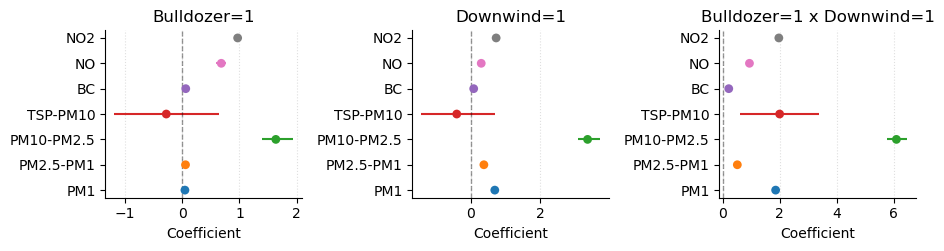

In [11]:
plot_summary_ys_subset2 = plot_summary_ys_subset.query("response != 'co'")

plot_coefficients_by_response(
    plot_summary_ys_subset2, 
    shape_map = {"pm1":"o", "pm25mpm1":"o", "pm10mpm25":"o", "tspmpm10":"o", "bc":"o", "co":"o", "no":"o", "no2":"o"}, 
    color_map = {"pm1":"tab:blue", "pm25mpm1":"tab:orange", "pm10mpm25":"tab:green", "tspmpm10":"tab:red", "bc":"tab:purple", 
                 "co":"tab:brown", "no":"tab:pink", "no2":"tab:grey"},  
)

/Users/borajin/Documents/BoraJin2018~/Research/GeomNMF-CurtisBay/src/utils.py:2226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("response", as_index=True)["label_y"]
/Users/borajin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


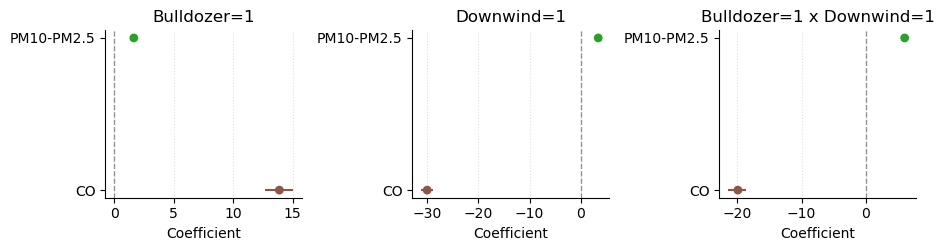

In [12]:
co_separate = ["co", "pm10mpm25"]
plot_summary_ys_subset3 = (plot_summary_ys_subset
    .query("response in @co_separate")
    .assign(response=lambda d: pd.Categorical(
          d["response"],                 # <-- use d (the filtered df), not plot_summary_ys
          categories=co_separate,
          ordered=True
      ))
    .sort_values(["response", "term"])
)

plot_coefficients_by_response(
    plot_summary_ys_subset3, 
    # figsize=(12, 4),
    # height=2.6/7,
    # aspect=1.2*8.45,
    shape_map = {"pm1":"o", "pm25mpm1":"o", "pm10mpm25":"o", "tspmpm10":"o", "bc":"o", "co":"o", "no":"o", "no2":"o"}, 
    color_map = {"pm1":"tab:blue", "pm25mpm1":"tab:orange", "pm10mpm25":"tab:green", "tspmpm10":"tab:red", "bc":"tab:purple", 
                 "co":"tab:brown", "no":"tab:pink", "no2":"tab:grey"},  
)

In [13]:
plot_summary_ss = (summary_ss
    .query("term in @ordered_x")
    .copy()
)

source_labels = {f"Source{k}": f"Source {k}" for k in range(1, K+1)}
plot_summary_ss["label_y"] = plot_summary_ss["response"].map(lambda s: source_labels.get(s, s))
plot_summary_ss["label_x"] = plot_summary_ss["term"].map(pretty_x)

In [14]:
plot_summary_ss_subset = (plot_summary_ss
    .query("term in @ordered_x_subset")
    .copy()
)

/Users/borajin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


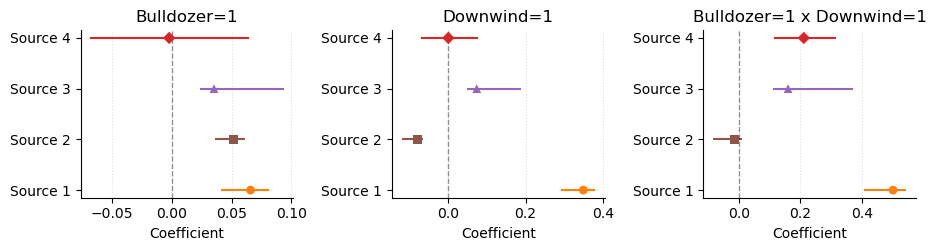

In [15]:
plot_coefficients_by_response(
    plot_summary_ss_subset, 
    color_map = {"Source1": "tab:orange", "Source2": "tab:brown", "Source3": "tab:purple", "Source4": "tab:red"}, 
)

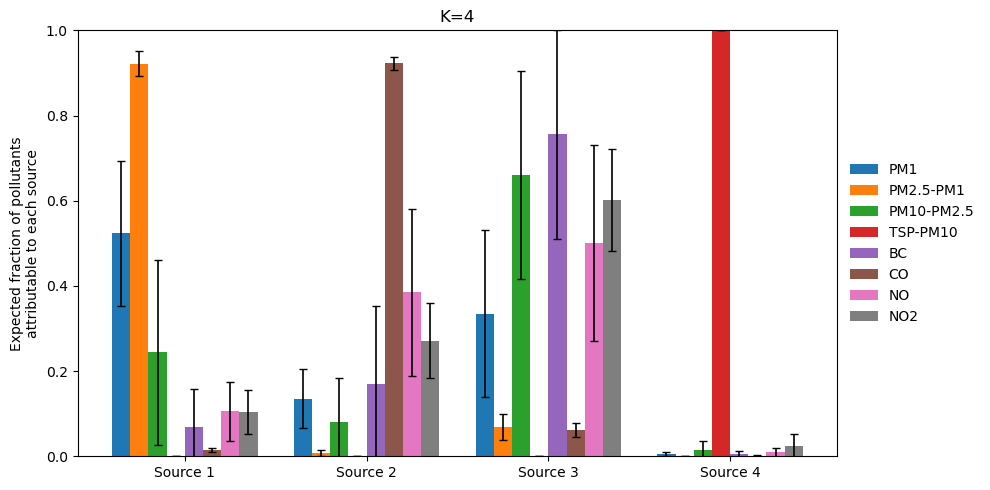

In [16]:
plot_C_matrix_grouped_by_k(
    results_boots["C_hat_sourceXray"], 
    title="K=4", 
    col_label=col_label, 
    # savepath="results/CB/figure/CB_nonegpm25mpm1_sourceXray_K4_bootstrap_Phi.pdf"
)

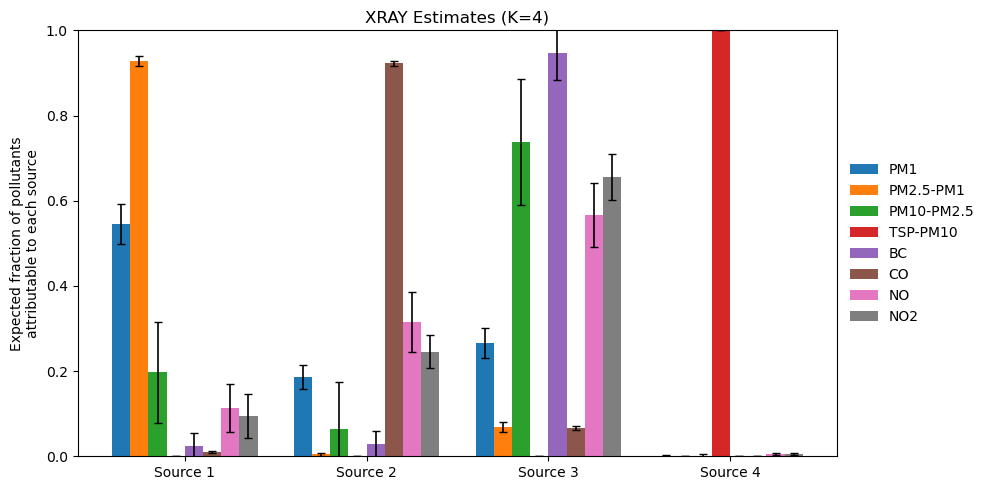

In [17]:
plot_C_matrix_grouped_by_k(
    results_boots["C_hat_xray"], 
    title="XRAY Estimates (K=4)", 
    col_label=col_label, 
    # savepath="results/CB/figure/CB_nonegpm25mpm1_XRAY_K4_bootstrap_Phi.png"
)

In [18]:
summary_phi = summarize_bootstrap_phi(results_boots["C_hat_sourceXray"], tau=0.03)

In [19]:
summary_phi["cv_mean"]

0.05049250391801746

In [20]:
summary_phi["R"]

0.85875

In [21]:
summary_phi["G"]

1.0

In [22]:
summary_phi["row_stability_mean"]

0.03173712011099062

In [23]:
np.exp(results_boots["logvol_sourceXray"].mean())

0.20325995369029556

In [24]:
results_boots["logvol_sourceXray"].std()

0.05215795554502325